**Importing Libraries** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objs as go



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv


Loading the Dataset

In [2]:
df=pd.read_csv('../input/paysim1/PS_20174392719_1491204439457_log.csv')

Knowing the Dataset

In [3]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

Preprocessing

In [9]:
df=df.rename(columns = {'nameOrig' : 'origin', 'oldbalanceOrg' : 'sender_old_balance',
                        'newbalanceOrig': 'sender_new_balance', 'nameDest' : 'destination',
                        'oldbalanceDest' : 'receiver_old_balance',
                        'newbalanceDest': 'receiver_new_balance', 'isFraud' : 'isfraud'})

In [10]:
df=df.drop(columns = ['step', 'isFlaggedFraud'], axis = 'columns')

In [11]:
df.head()

,type,amount,origin,sender_old_balance,sender_new_balance,destination,receiver_old_balance,receiver_new_balance,isfraud
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [12]:
cols = df.columns.tolist()
new_position = 3

cols.insert(new_position, cols.pop(cols.index('destination')))
df = df[cols]

In [13]:
df.head()

,type,amount,origin,destination,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud
0,PAYMENT,9839.64,C1231006815,M1979787155,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,C1666544295,M2044282225,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,C1305486145,C553264065,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,C840083671,C38997010,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,C2048537720,M1230701703,41554.0,29885.86,0.0,0.0,0


In [14]:
df['isfraud'].value_counts()

isfraud
0    6354407
1       8213
Name: count, dtype: int64

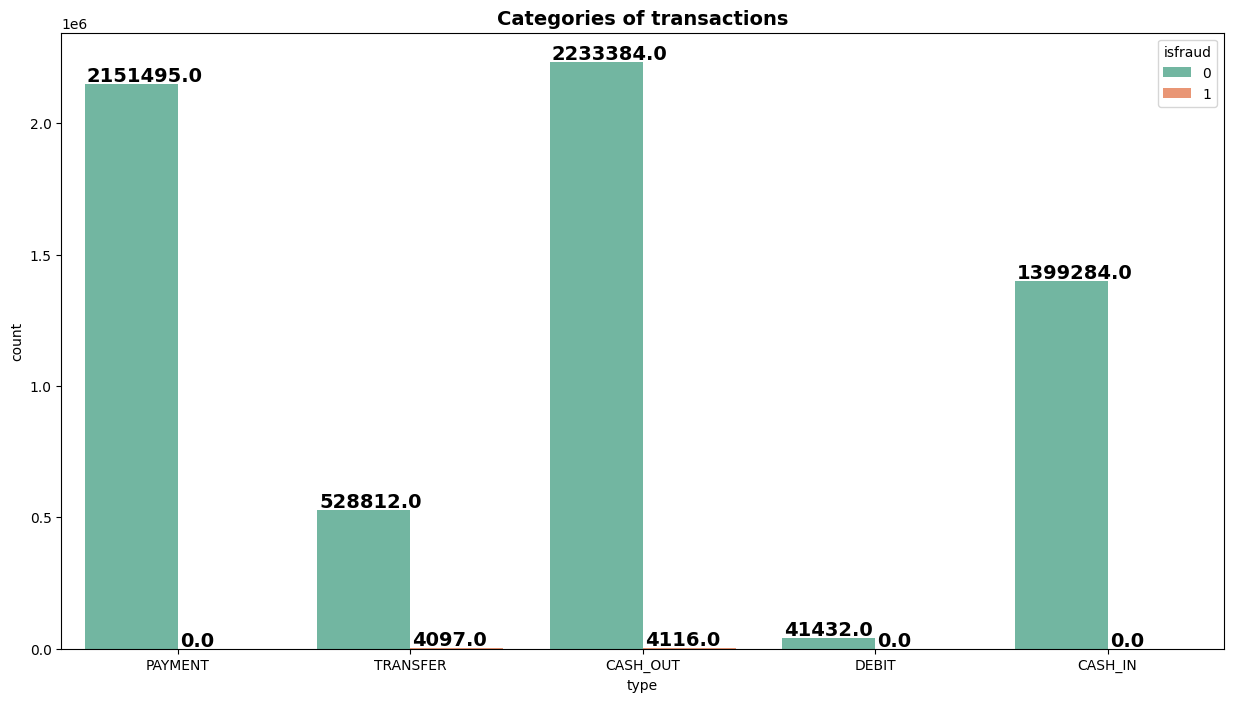

In [15]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = df, x = "type", hue="isfraud", palette = 'Set2')
plt.title('Categories of transactions',fontsize=14, fontweight='bold')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000),
                    fontsize=14, fontweight='bold')

In [16]:
t_fraud = df[((df['type']=='TRANSFER') & df['isfraud']==1)]
t_fraud['origin'].value_counts()

origin
C1305486145    1
C202278158     1
C12585107      1
C946427395     1
C1069177491    1
              ..
C2090764492    1
C1794935564    1
C318078280     1
C939293281     1
C1685995037    1
Name: count, Length: 4097, dtype: int64

In [17]:
cash_out_fraud = df[(df['type'] == 'CASH_OUT') & (df['isfraud'] == 1)]
cash_out_fraud['destination'].value_counts()

destination
C200064275     2
C1399829166    2
C1650668671    2
C2129197098    2
C1013511446    2
              ..
C1566713324    1
C1955464150    1
C1104137869    1
C377165949     1
C873221189     1
Name: count, Length: 4091, dtype: int64

In [18]:
fraud_trans = df[df['isfraud'] == 1]
valid_trans = df[df['isfraud'] == 0]

trans_transfer = df[df['type'] == 'TRANSER']
trans_cashout = df[df['type'] == 'CASH_OUT']

print('Has the receiving account used for cashing out?')
trans_transfer.destination.isin(trans_cashout.origin).any()

Has the receiving account used for cashing out?


False

In [19]:
df1 = df.copy()
df1['type2'] = pd.NA
df1.loc[df.origin.str.contains('C') & df.destination.str.contains('C'), 'type2'] = 'CC'
df1.loc[df.origin.str.contains('C') & df.destination.str.contains('M'), 'type2'] = 'CM'
df1.loc[df.origin.str.contains('M') & df.destination.str.contains('C'), 'type2'] = 'MC'
df1.loc[df.origin.str.contains('M') & df.destination.str.contains('C'), 'type2'] = 'MM'

In [20]:
df1.head()

,type,amount,origin,destination,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud,type2
0,PAYMENT,9839.64,C1231006815,M1979787155,170136.0,160296.36,0.0,0.0,0,CM
1,PAYMENT,1864.28,C1666544295,M2044282225,21249.0,19384.72,0.0,0.0,0,CM
2,TRANSFER,181.00,C1305486145,C553264065,181.0,0.00,0.0,0.0,1,CC
3,CASH_OUT,181.00,C840083671,C38997010,181.0,0.00,21182.0,0.0,1,CC
4,PAYMENT,11668.14,C2048537720,M1230701703,41554.0,29885.86,0.0,0.0,0,CM


In [21]:
cols = df1.columns.tolist()
new_position = 1

cols.insert(new_position, cols.pop(cols.index('type2')))
df1 = df1[cols]

In [22]:
df1.head()

,type,type2,amount,origin,destination,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud
0,PAYMENT,CM,9839.64,C1231006815,M1979787155,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,CM,1864.28,C1666544295,M2044282225,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,CC,181.00,C1305486145,C553264065,181.0,0.00,0.0,0.0,1
3,CASH_OUT,CC,181.00,C840083671,C38997010,181.0,0.00,21182.0,0.0,1
4,PAYMENT,CM,11668.14,C2048537720,M1230701703,41554.0,29885.86,0.0,0.0,0


In [23]:
df1.drop(columns = ['origin','destination'], axis = 'columns', inplace = True)

In [24]:
df1.head()

,type,type2,amount,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud
0,PAYMENT,CM,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,CM,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,CC,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,CC,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,CM,11668.14,41554.0,29885.86,0.0,0.0,0


In [25]:
fraud_trans = df1[df1['isfraud'] == 1]
valid_trans = df1[df1['isfraud'] == 0]

print('Number of fraud transactions are below:\n', fraud_trans.type2.value_counts(), '\n')
print('Number of valid transactions are below:\n', valid_trans.type2.value_counts())

Number of fraud transactions are below:
 type2
CC    8213
Name: count, dtype: int64 

Number of valid transactions are below:
 type2
CC    4202912
CM    2151495
Name: count, dtype: int64


Visualization 

In [26]:
fr = fraud_trans.type2.value_counts()
va = valid_trans.type2.value_counts()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


Text(0.5, 1.0, 'Valid')

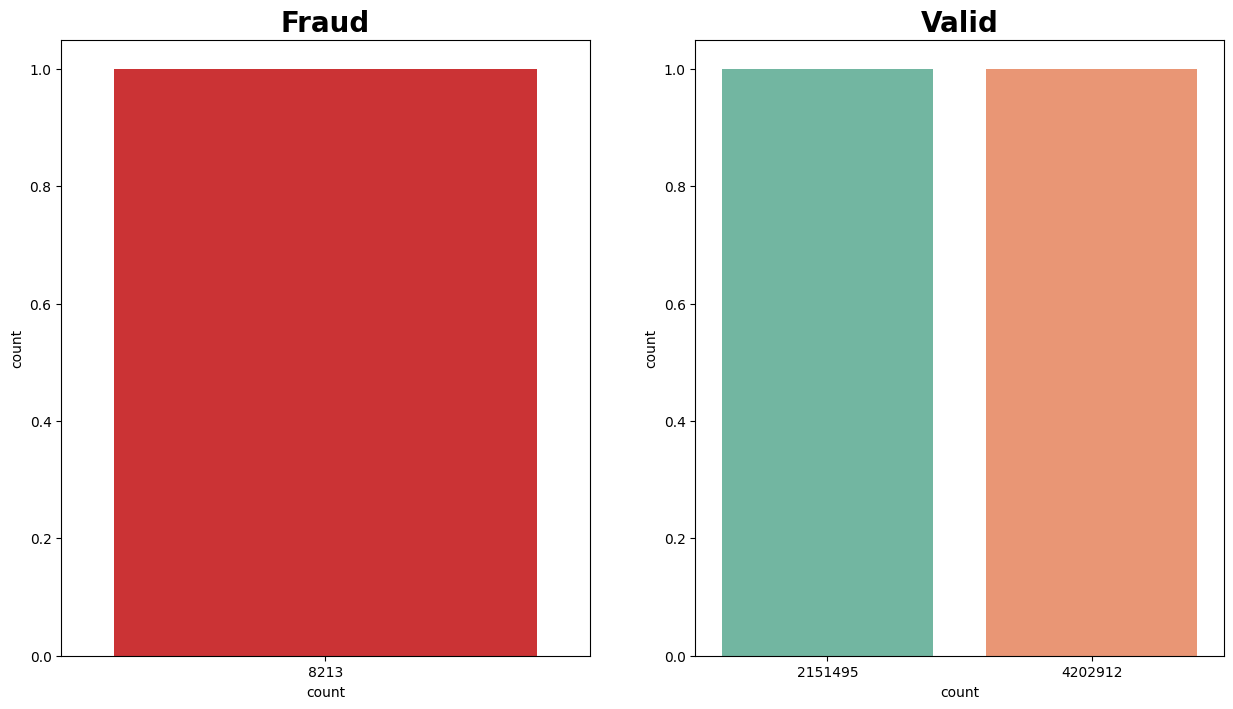

In [27]:
plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
sns.countplot(x = fr, palette='Set1')
plt.title('Fraud',fontweight="bold", fontsize=20)
plt.subplot(1,2,2)
sns.countplot(x = va, palette='Set2')
plt.title('Valid',fontweight="bold", fontsize=20)

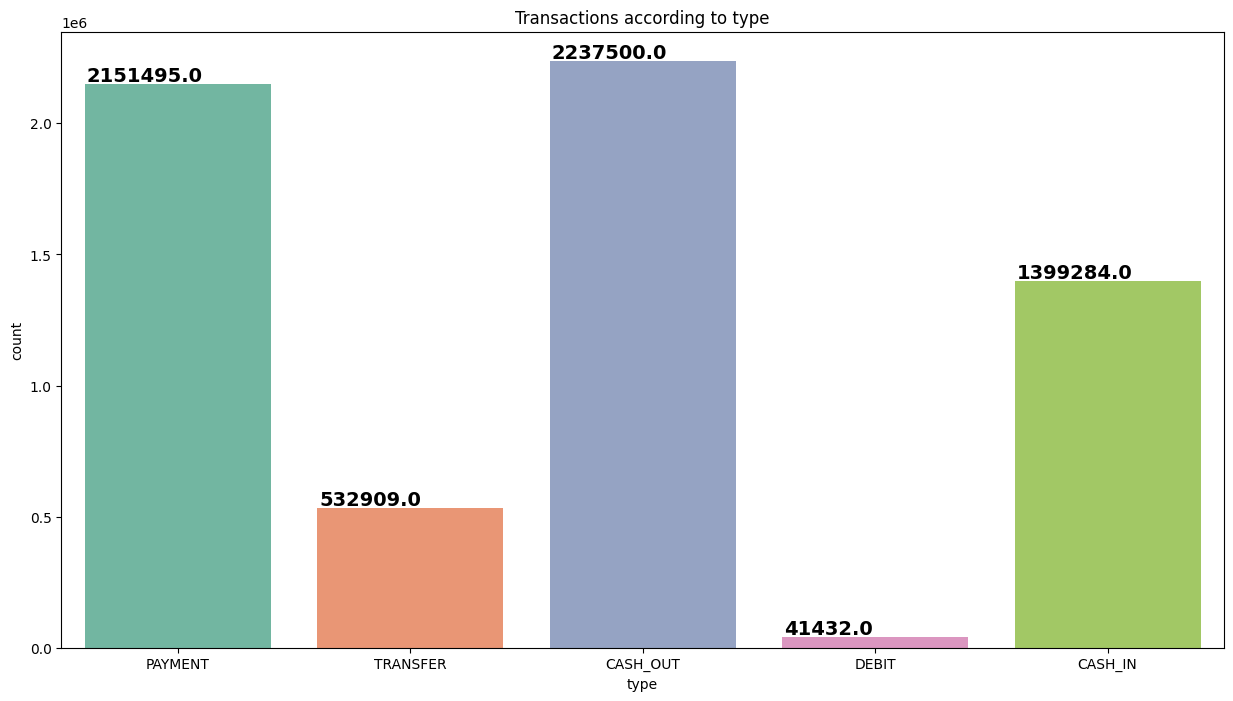

In [28]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = df1, x = "type",palette = 'Set2')
plt.title('Transactions according to type')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000),
                   fontsize=14, fontweight='bold')

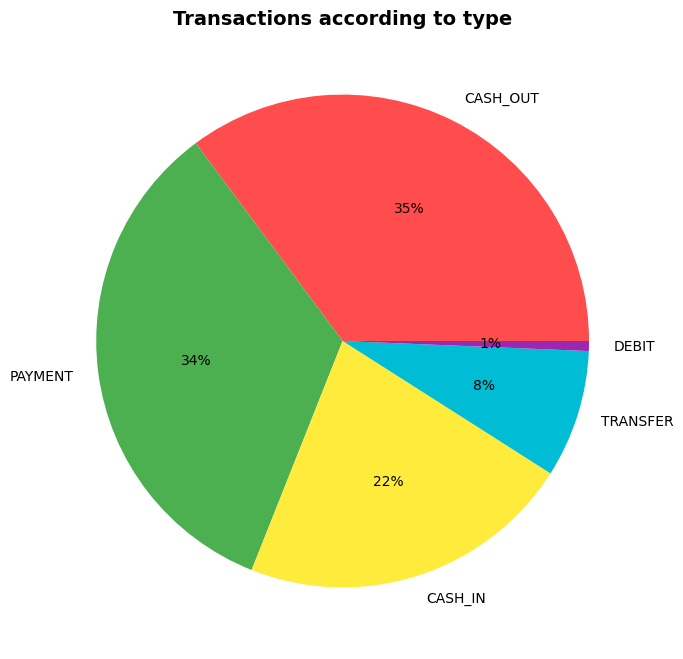

In [29]:
plt.figure(figsize=(15,8))
colors = ['#FF4C4C', '#4CAF50', '#FFEB3B', '#00BCD4', '#9C27B0']
plt.pie(df1.type.value_counts().values,labels=df1.type.value_counts().index, colors = colors,
        autopct='%.0f%%',)
plt.title("Transactions according to type",fontsize=14, fontweight='bold')
plt.show()


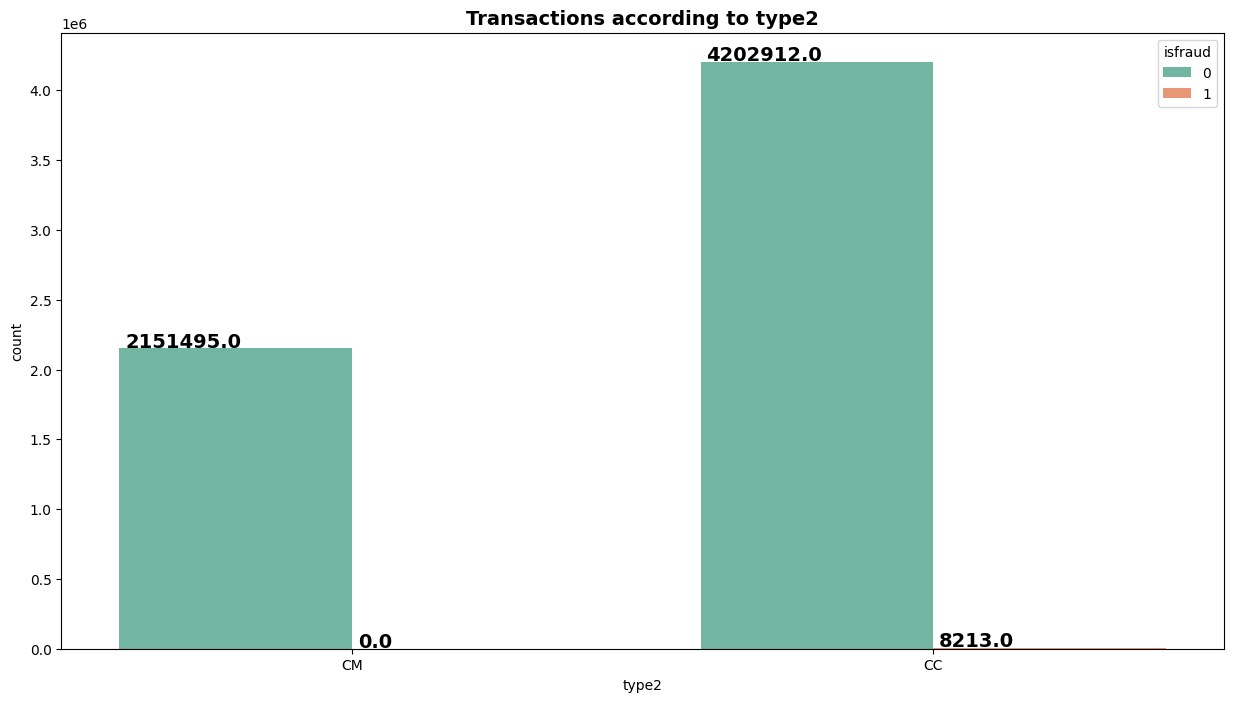

In [30]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = df1, x = "type2", hue="isfraud", palette = 'Set2')
plt.title('Transactions according to type2',fontsize=14, fontweight='bold')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000),
                    fontsize=14, fontweight='bold')

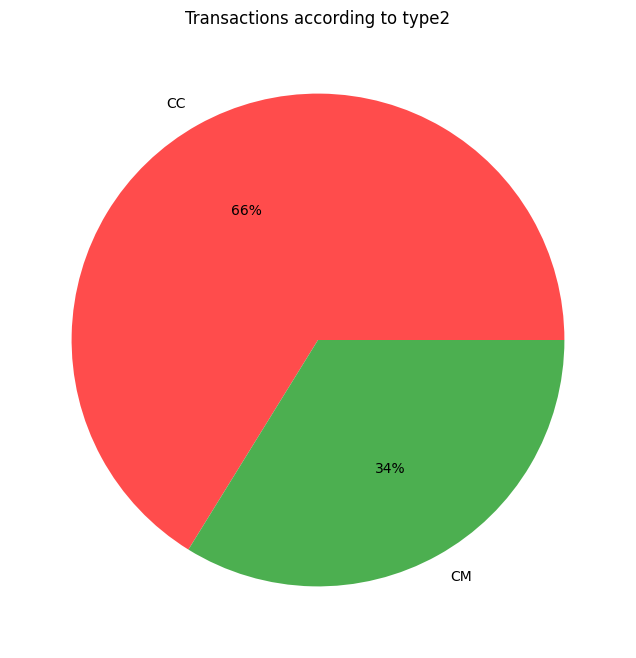

In [31]:
plt.figure(figsize=(15,8))
colors = ['#FF4C4C', '#4CAF50']
plt.pie(df1.type2.value_counts().values,labels=df1.type2.value_counts().index, colors = colors,  autopct='%.0f%%')
plt.title("Transactions according to type2")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

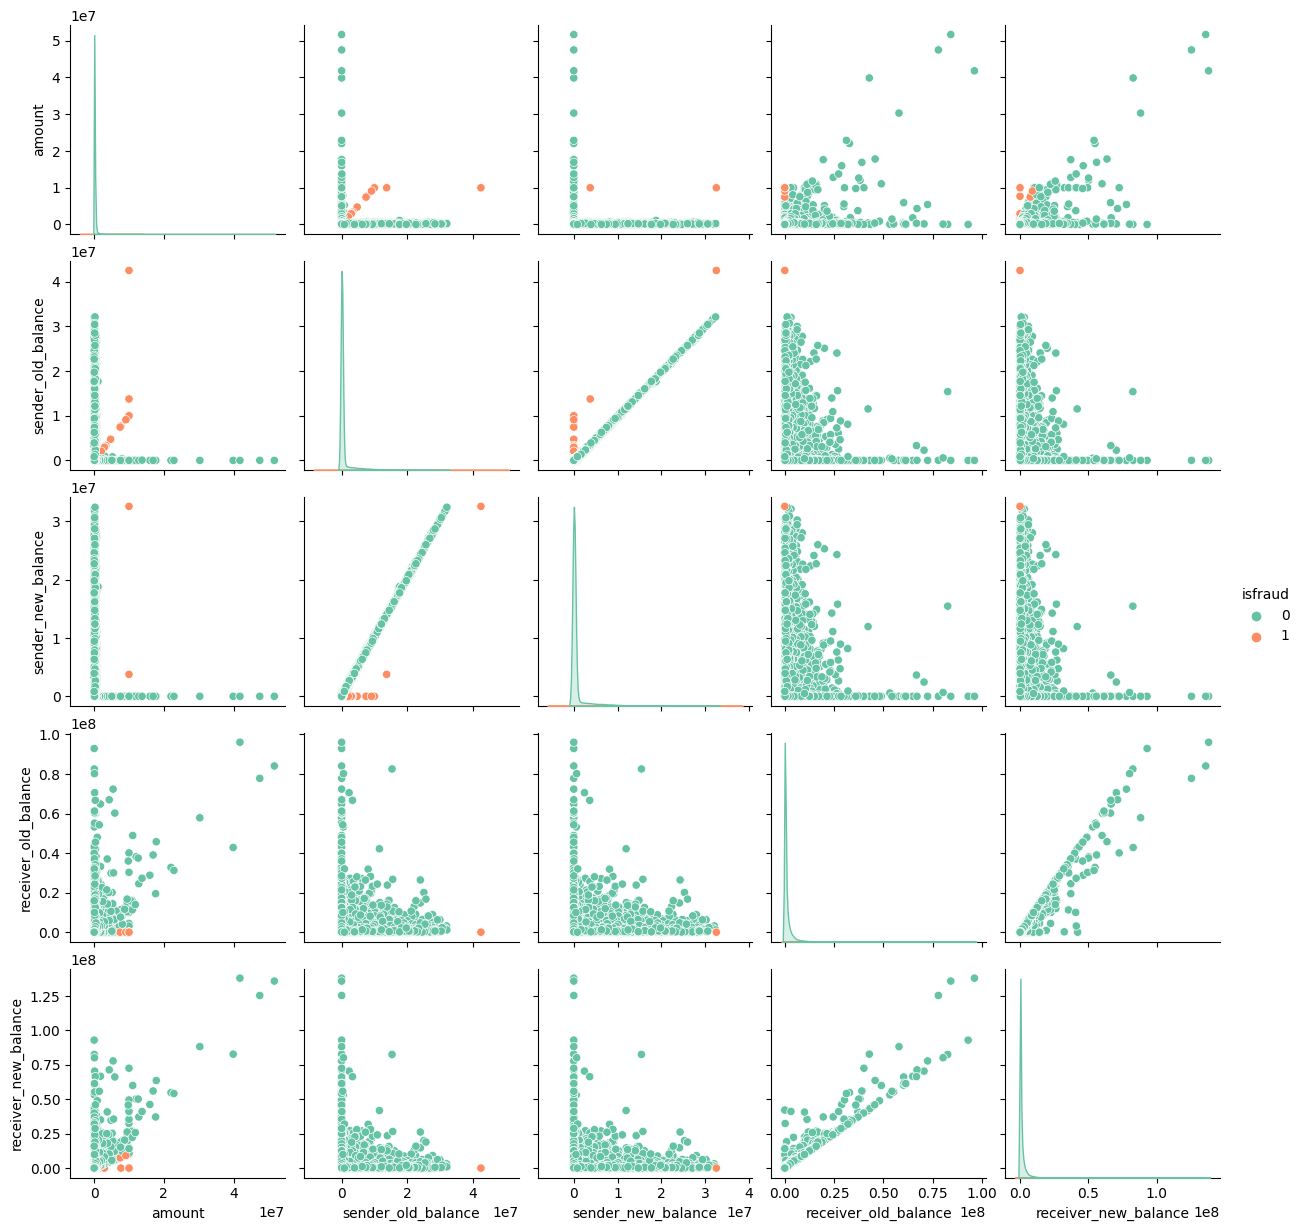

In [32]:
df_sample = df1.sample(50000) if len(df1) > 50000 else 1

sns.pairplot(df_sample, hue="isfraud", diag_kind="kde", palette="Set2")
plt.show()